# Surfaces

## Disk integrated phase functions

The `photometry` submodule contains classes for the following phase function models:
* H, G from Bowell et al. 1989
* H, G1, G2 from Muinonen et al. 2010
* H, G12 from Muinonen et al. 2010
* H, G12 from Penttilä et al. 2016

Here, we will use the H, G model, but the other classes have similar functionality.

Firstly, the `HG` class is an astropy model:

In [1]:
import astropy.units as u
from sbpy.photometry import HG

model = HG(H=7.25 * u.mag, G=0.19)  # (24) Themis
print(model)

Model: HG
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
     H    G  
    mag      
    ---- ----
    7.25 0.19


Therefore, the astropy fitting mechanisms may be used to, e.g., fit observational data.

Get ZTF r-band photometry of (90) Antiope, convert to absolute magnitude, and fit a phase function to it.

In [2]:
from sbpy.data import Obs

phot = Obs.from_mpc('90')
phot.field_names

['number',
 'desig',
 'discovery',
 'note1',
 'note2',
 'epoch',
 'RA',
 'DEC',
 'mag',
 'band',
 'observatory']

In [3]:
from astropy.time import Time

# need a time limit here to keep out PTF photometry 
ztf = (phot['observatory'] == 'I41') * (phot['epoch'] > Time('2017-10-15'))
r = phot['band'] == 'r'
phot = phot[ztf * r]
phot.table.show_in_notebook()

idx,number,desig,discovery,note1,note2,epoch,RA,DEC,mag,band,observatory
,,,,,,,deg,deg,mag,,
0,90,,--,--,C,2458104.6688,11.419333333333332,3.114888888888889,13.4,r,I41
1,90,,--,--,C,2458104.7044,11.422916666666666,3.1170833333333334,13.4,r,I41
2,90,,--,--,C,2458104.71634,11.424166666666666,3.1178333333333335,13.4,r,I41
3,90,,--,--,C,2458105.593,11.519124999999999,3.172861111111111,13.4,r,I41
4,90,,--,--,C,2458105.62682,11.522666666666666,3.175027777777778,13.4,r,I41
5,90,,--,--,C,2458105.67588,11.527833333333334,3.178138888888889,13.4,r,I41
6,90,,--,--,C,2458105.68878,11.529166666666665,3.178972222222222,13.4,r,I41
7,90,,--,--,C,2458105.74833,11.535458333333333,3.18275,13.4,r,I41
8,90,,--,--,C,2458105.77052,11.537916666666666,3.1841666666666666,13.4,r,I41


In [4]:
# get ephemeris data
from sbpy.data import Orbit, Ephem

orbit = Orbit.from_horizons('90')
eph = Ephem.from_oo(orbit, location='I41', epochs=phot['epoch'])
eph.table.show_in_notebook()

idx,targetname,RA,DEC,RA*cos(Dec)_rate,DEC_rate,alpha,elong,r,Delta,V,pa,TopEclLon,TopEclLat,OppTopEclLon,OppTopEclLat,HelEclLon,HelEclLat,OppHelEclLon,OppHelEclLat,EL,ELsun,ELmoon,lunarphase,lunarelong,x,y,z,vx,vy,vz,obsx,obsy,obsz,trueanom,epoch
,,deg,deg,deg / d,deg / d,deg,deg,AU,AU,mag,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,deg,AU,AU,AU,AU / d,AU / d,AU / d,AU,AU,AU,deg,
0,90 Antiope (A866 TA),11.419306920392813,3.1148793954485416,0.10040310068821387,0.06180213669059671,18.701937695752253,106.553890495091,2.9420343392009376,2.506295294388656,13.51720072836852,58.38603574123443,11.717148126433873,-1.6494499318137255,-73.43910207269096,-1.6477098584374663,30.424220705512475,-1.405682036481958,-54.73202949361236,-1.4039419631056989,55.518014951543606,-41.03514961670364,-49.46244054987333,0.013049631658086758,119.04596857209478,2.5361518029461636,1.4893929268247301,-0.07217198192433538,-0.0038144279523004386,0.00962326181497305,0.00026513949262484864,0.08309944352227991,0.9806244025685203,-2.9888313475834316e-05,75.08864876381146,2458104.669600741
1,90 Antiope (A866 TA),11.422896762170593,3.117079352603292,0.10105130318127897,0.061808596443458895,18.70486796348093,106.52153504449718,2.942090477933276,2.5068322904671634,13.517801445821195,58.547725331014455,11.72130856777625,-1.64882242727199,-73.47148190362871,-1.6469340308534794,30.43131443625916,-1.4054713400231902,-54.761476035145805,-1.4035829436046794,48.27078264567365,-51.751242568291445,-59.34282709183442,0.012126326520984387,118.50227516489659,2.536016002472619,1.4897354741363373,-0.07216254324947541,-0.0038154768098275327,0.009622645803092321,0.00026516933793197667,0.082474238893395,0.9806796198831559,-3.2436059414442386e-05,75.09578082759137,2458104.705200741
2,90 Antiope (A866 TA),11.424106459641076,3.117817268868078,0.10131942837093229,0.06181228637982556,18.705845461836464,106.51067157434339,2.942109306884306,2.507012766662731,13.518003051038344,58.61374475683628,11.722709207237294,-1.6486141160782584,-73.48235335139609,-1.646681928779547,30.433693564319753,-1.4054006708443871,-54.771368994313626,-1.4034684835456759,45.38681039544882,-55.333251753456096,-62.494125735613935,0.011816600079384731,118.31558165650506,2.5359704475581055,1.489850357260242,-0.07215937734432526,-0.003815828563461328,0.00962243917308478,0.0002651793465875832,0.08226423348090896,0.9806978180124776,-3.318825269638115e-05,75.09817281212713,2458104.7171407407
3,90 Antiope (A866 TA),11.519103970828217,3.1728511484524664,0.10453279072801766,0.06360686909530033,18.771537689834485,105.72824576775707,2.94349231916968,2.5201752755189113,13.532502569343366,58.680020941500615,11.831560311470797,-1.634930250970051,-74.26522311436972,-1.6335692544270015,30.608290706771097,-1.4002078548350554,-55.48849271906941,-1.398846858292006,59.11207965803141,-18.506017776060503,-18.92523763013918,0.0014988949094977277,108.45259430230323,2.5326142443314725,1.4982785742596811,-0.0719266038027821,-0.003841619326611711,0.009607235327103366,0.0002659124787899921,0.06698533989150231,0.9817641838103526,-2.3374918652008247e-05,75.2737129871025,2458105.593800741
4,90 Antiope (A866 TA),11.52264543106562,3.1750020366508855,0.104651184319086,0.06360575633864624,18.774170933330247,105.69783371219744,2.9435456949889827,2.5206840101207533,13.533064703241696,58.70925895810787,11.835656800547868,-1.6343283825860677,-74.29565845217316,-1.6327950251275716,30.615023053626555,-1.4000073623871567,-55.51629219909446,-1.3984740049286606,59.86104605003305,-28.40706694238399,-28.626631112830086,0.0013648494045115922,108.01773443941171,2.532484315253532,1.4986034527915328,-0.07191761094696775,-0.0038426128750638265,0.009606647502463261,0.00026594069356805075,0.06639389103434482,0.9818083214766091,-2.6335298229873683e-05,75.28048168333106,2458105.627620741
5,90 Antiope (A866 TA),11.52779889241966,3.1781221213258197,0.10522996324509497,0.06360645329631597,18.7779755918143,105.6535763677022,2.9436231258881604,2.521424959652698,13.5338

In [5]:
import numpy as np
# H(1, 1, alpha)
H11a = phot['mag'] - 5 * np.log10(eph['rh'].value * eph['delta'].value) * u.mag

In [6]:
from astropy.modeling import fitting

fitter = fitting.LevMarLSQFitter()
model = HG()
fit = fitter(model, eph['phase'], H11a)
print(fit)

Model: HG
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            H                  G         
           mag                           
    ----------------- -------------------
    8.140808681932176 0.21731904153171716


[Text(0, 0.5, 'H(1,1,α) (mag)'), Text(0.5, 0, 'α (deg)')]

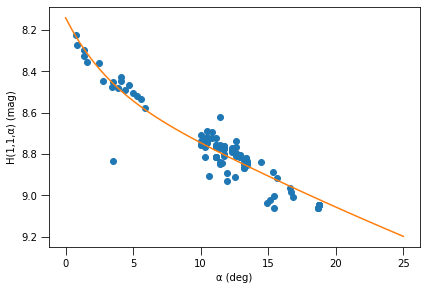

In [7]:
import matplotlib.pyplot as plt

plt.clf()
ax = plt.gca()
ax.scatter(eph['phase'], H11a)

alpha = np.linspace(0, 25) * u.deg
ax.plot(alpha, fit(alpha), color='tab:orange')
ax.invert_yaxis()
plt.setp(ax, ylabel='H(1,1,α) (mag)', xlabel='α (deg)')

[Text(0, 0.5, 'H(1,1,α) (mag)'), Text(0.5, 0, 'α (deg)')]

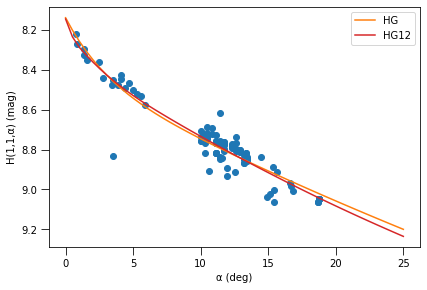

In [8]:
# compare with the HG12 model
from sbpy.photometry import HG12

model = HG12()
fit12 = fitter(model, eph['phase'], H11a)

plt.clf()
ax = plt.gca()
ax.scatter(eph['phase'], H11a)

alpha = np.linspace(0, 25) * u.deg
ax.plot(alpha, fit(alpha), color='tab:orange', label='HG')
ax.plot(alpha, fit12(alpha), color='tab:red', label='HG12')
ax.invert_yaxis()
plt.legend()
plt.setp(ax, ylabel='H(1,1,α) (mag)', xlabel='α (deg)')